In [1]:
from math import ceil
from typing import Any, Dict, Literal, Tuple

import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import polars as pl
import seaborn as sns
import sidetable
from catboost import CatBoostClassifier, Pool
from imblearn.combine import SMOTEENN
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    PrecisionRecallDisplay,
    RocCurveDisplay,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    recall_score,
)
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split

# To run the pipeline put files `conv_predict_fields_description.csv` and `conv_predict_test_data.csv` in the same directory as this notebook.

In [2]:
def generate_features(df: pl.DataFrame) -> pl.DataFrame:
    """
    Generate new features from the existing columns in a Polars DataFrame.

    Parameters
    ----------
    df : pl.DataFrame
        The input Polars DataFrame containing columns such as:
        'sessions', 'sessions_length', 'spins_total', 'regular_spins', 'free_spins',
        'coins_start_day', 'coins_end_day', 'spend_coins', 'gems_start_day',
        'gems_end_day', 'spend_gems_slot', 'spend_gems_other', 'ups_start_day',
        'ups_end_day', 'spend_ups', 'hourly_bonus', 'daily_bonus',
        'points_start_day', 'points_end_day', 'jp_count', 'total_win_jp',
        'win_jp_bet', etc.

    Returns
    -------
    pl.DataFrame
        The original Polars DataFrame with additional generated feature columns.
    """

    df = df.with_columns(
        [
            # 1. Average session length (seconds per session)
            (pl.col("sessions_length") / pl.col("sessions")).alias(
                "avg_session_length"
            ),
            # 2. Ratio of free spins to total spins
            (pl.col("free_spins") / pl.col("spins_total")).alias(
                "ratio_free_spins"
            ),
            # 3. Net change in coins
            (pl.col("coins_end_day") - pl.col("coins_start_day")).alias("net_coins"),
            # 4. Total gems spent (slots + other)
            (pl.col("spend_gems_slot") + pl.col("spend_gems_other")).alias(
                "total_gems_spent"
            ),
            # 5. Net change in gems
            (pl.col("gems_end_day") - pl.col("gems_start_day")).alias("net_gems"),
            # 6. Net change in boosts (ups)
            (pl.col("ups_end_day") - pl.col("ups_start_day")).alias("net_ups"),
            # 7. Net jackpot coins
            (pl.col("total_win_jp") - pl.col("win_jp_bet")).alias("net_win_jp"),
            # 8. Spin success rate (fraction of spins that yielded any win)
            (pl.col("winning_spins") / pl.col("spins_total").fill_null(1)).alias(
                "spin_success_rate"
            ),
            # 9. Difference between regular spins and free spins
            (pl.col("regular_spins") - pl.col("free_spins")).alias("spins_diff"),
            # 10. Coins spent per session (if sessions > 0)
            (pl.col("spend_coins") / pl.col("sessions").fill_null(1)).alias(
                "spend_coins_per_session"
            ),
        ]
    )

    return df


def split_data(
    X: pd.DataFrame,
    y: pd.Series,
    val_size: float = 0.1,
    test_size: float = 0.1,
    random_state: int = 42,
    use_stratification: bool = False,
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]:
    """
    Split input data into train, validation, and test sets, optionally using stratification.

    Parameters
    ----------
    X : pd.DataFrame
        Feature matrix.
    y : pd.Series
        Target variable.
    val_size : float, optional
        Proportion of the data to include in the validation set, by default 0.1.
    test_size : float, optional
        Proportion of the data to include in the test set, by default 0.1.
    random_state : int, optional
        Random seed for reproducible splits, by default 42.
    use_stratification : bool, optional
        If True, data splits will be stratified using the target variable. By default False.

    Returns
    -------
    Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]
        A tuple containing:
        - X_train: pd.DataFrame
            Training feature matrix
        - X_val: pd.DataFrame
            Validation feature matrix
        - X_test: pd.DataFrame
            Test feature matrix
        - y_train: pd.Series
            Training target vector
        - y_val: pd.Series
            Validation target vector
        - y_test: pd.Series
            Test target vector

    Raises
    ------
    ValueError
        If the sum of val_size and test_size is greater than or equal to 1.
    """
    # Check that the requested splits are valid
    if val_size + test_size >= 1:
        raise ValueError("val_size + test_size must be less than 1.")

    # Determine stratification parameters
    stratify_test = y if use_stratification else None

    # First split off the test set
    X_temp, X_test, y_temp, y_test = train_test_split(
        X,
        y,
        test_size=test_size,
        random_state=random_state,
        stratify=stratify_test,  # stratify if specified
    )

    # Adjust val_size proportion relative to the remaining data after removing test
    adjusted_val_size = val_size / (1 - test_size)

    # For the second split (train/val), stratify on the reduced dataset if needed
    stratify_val = y_temp if use_stratification else None

    # Split the remaining data into train and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp,
        y_temp,
        test_size=adjusted_val_size,
        random_state=random_state,
        stratify=stratify_val,  # stratify if specified
    )

    return X_train, X_val, X_test, y_train, y_val, y_test

In [3]:
fields_descriprion = pl.read_csv("conv_predict_fields_description.csv")
df = pl.read_csv(
    "conv_predict_test_data.csv",
    separator=";",  # Custom delimiter
    infer_schema_length=10000,  # Adjust if the data set is large
    try_parse_dates=True,  # Automatically parse date columns
)

In [4]:
fields_descriprion

shape: (44, 1)
┌─────────────────────────────────┐
│ progress_id;Unique user identi… │
│ ---                             │
│ str                             │
╞═════════════════════════════════╡
│ action_date;Date when the user… │
│ entry_date;Date when the user … │
│ sessions;Number of user sessio… │
│ sessions_length;Total session … │
│ level;Level                     │
│ …                               │
│ bg_count;Number of bonus games  │
│ fs_count;Number of free spin g… │
│ freespins;Number of free spins  │
│ sum_coins;Sum of received/spen… │
│ is_first_payment;Whether the u… │
└─────────────────────────────────┘

In [5]:
df.head(10)

shape: (10, 43)
┌────────────┬───────────┬───────────┬──────────┬───┬──────────┬───────────┬───────────┬───────────┐
│ �progress_ ┆ action_da ┆ entry_dat ┆ sessions ┆ … ┆ fs_count ┆ freespins ┆ sum_coins ┆ is_first_ │
│ id         ┆ te        ┆ e         ┆ ---      ┆   ┆ ---      ┆ ---       ┆ ---       ┆ payment   │
│ ---        ┆ ---       ┆ ---       ┆ i64      ┆   ┆ i64      ┆ i64       ┆ i64       ┆ ---       │
│ str        ┆ datetime[ ┆ datetime[ ┆          ┆   ┆          ┆           ┆           ┆ bool      │
│            ┆ μs, UTC]  ┆ μs, UTC]  ┆          ┆   ┆          ┆           ┆           ┆           │
╞════════════╪═══════════╪═══════════╪══════════╪═══╪══════════╪═══════════╪═══════════╪═══════════╡
│ 5996422dd7 ┆ 2023-04-0 ┆ 2023-03-2 ┆ 23       ┆ … ┆ 41       ┆ 2098      ┆ 327166143 ┆ false     │
│ 2a657f8382 ┆ 1         ┆ 8         ┆          ┆   ┆          ┆           ┆           ┆           │
│ c0668af    ┆ 00:00:00  ┆ 00:00:00  ┆          ┆   ┆          ┆           ┆           ┆           │
│            ┆ UTC       ┆ UTC       ┆          ┆   ┆          ┆           ┆           ┆           │
│ 343641c684 ┆ 2023-03-2 ┆ 2023-03-2 ┆ 14       ┆ … ┆ 75       ┆ 2651      ┆ 136295100 ┆ false     │
│ 35d3b9631c ┆ 4         ┆ 3         ┆          ┆   ┆          ┆           ┆ 1         ┆           │
│ 8034dd0    ┆ 00:00:00  ┆ 00:00:00  ┆          ┆   ┆          ┆           ┆           ┆           │
│            ┆ UTC       ┆ UTC       ┆          ┆   ┆          ┆           ┆           ┆           │
│ 489641c8ce ┆ 2023-03-2 ┆ 2023-03-2 ┆ 14       ┆ … ┆ 86       ┆ 691       ┆ 3600000   ┆ false     │
│ b220f936e2 ┆ 9         ┆ 3         ┆          ┆   ┆          ┆           ┆           ┆           │
│ f0559b9    ┆ 00:00:00  ┆ 00:00:00  ┆          ┆   ┆          ┆           ┆           ┆           │
│            ┆ UTC       ┆ UTC       ┆          ┆   ┆          ┆           ┆           ┆           │
│ 0756422875 ┆ 2023-03-2 ┆ 2023-03-2 ┆ 16       ┆ … ┆ 132      ┆ 2441      ┆ 312808483 ┆ false     │
│ 1e8fb66625 ┆ 9         ┆ 8         ┆          ┆   ┆          ┆           ┆           ┆           │
│ 00657c1    ┆ 00:00:00  ┆ 00:00:00  ┆          ┆   ┆          ┆           ┆           ┆           │
│            ┆ UTC       ┆ UTC       ┆          ┆   ┆          ┆           ┆           ┆           │
│ 1466421c6d ┆ 2023-03-3 ┆ 2023-03-2 ┆ 20       ┆ … ┆ 84       ┆ 663       ┆ 25186416  ┆ false     │
│ bda72929aa ┆ 0         ┆ 7         ┆          ┆   ┆          ┆           ┆           ┆           │
│ 70a6e15    ┆ 00:00:00  ┆ 00:00:00  ┆          ┆   ┆          ┆           ┆           ┆           │
│            ┆ UTC       ┆ UTC       ┆          ┆   ┆          ┆           ┆           ┆           │
│ 347641f03c ┆ 2023-03-2 ┆ 2023-03-2 ┆ 21       ┆ … ┆ 97       ┆ 1627      ┆ 703326872 ┆ false     │
│ 1ef201bff4 ┆ 9         ┆ 5         ┆          ┆   ┆          ┆           ┆           ┆           │
│ 10ed7e5    ┆ 00:00:00  ┆ 00:00:00  ┆          ┆   ┆          ┆           ┆           ┆           │
│            ┆ UTC       ┆ UTC       ┆          ┆   ┆          ┆           ┆           ┆           │
│ 2266421952 ┆ 2023-03-2 ┆ 2023-03-2 ┆ 27       ┆ … ┆ 115      ┆ 2453      ┆ 134980000 ┆ false     │
│ 8003d8697f ┆ 8         ┆ 7         ┆          ┆   ┆          ┆           ┆ 0         ┆           │
│ 6097ca3    ┆ 00:00:00  ┆ 00:00:00  ┆          ┆   ┆          ┆           ┆           ┆           │
│            ┆ UTC       ┆ UTC       ┆          ┆   ┆          ┆           ┆           ┆           │
│ 472641c03e ┆ 2023-03-2 ┆ 2023-03-2 ┆ 22       ┆ … ┆ 45       ┆ 1925      ┆ 800525578 ┆ false     │
│ abe29d589d ┆ 4         ┆ 3         ┆          ┆   ┆          ┆           ┆           ┆           │
│ 804f33e    ┆ 00:00:00  ┆ 00:00:00  ┆          ┆   ┆          ┆           ┆           ┆           │
│            ┆ UTC       ┆ UTC       ┆          ┆   ┆          ┆           ┆           ┆           │
│ 570641a18f ┆ 2023-03-2 ┆ 2023-03-2 ┆ 28    

In [6]:
df.shape

(165508, 43)

In [7]:
df = df.rename({"�progress_id": "progress_id"})

EDA

In [8]:
df = generate_features(df)

In [9]:
df.select("progress_id").n_unique()

98739

In [10]:
df.schema

Schema([('progress_id', String),
        ('action_date', Datetime(time_unit='us', time_zone='UTC')),
        ('entry_date', Datetime(time_unit='us', time_zone='UTC')),
        ('sessions', Int64),
        ('sessions_length', Int64),
        ('level', Int64),
        ('spins_total', Int64),
        ('regular_spins', Int64),
        ('free_spins', Int64),
        ('coins_start_day', Float64),
        ('coins_end_day', Float64),
        ('spend_coins', Float64),
        ('gems_start_day', Int64),
        ('gems_end_day', Int64),
        ('spend_gems_slot', Int64),
        ('spend_gems_other', Int64),
        ('ups_start_day', Int64),
        ('ups_end_day', Int64),
        ('spend_ups', Int64),
        ('hourly_bonus', Int64),
        ('daily_bonus', Int64),
        ('status_points_end_day', Int64),
        ('country_install', String),
        ('source', Int64),
        ('total_win_bg', Float64),
        ('total_win_fs', Float64),
        ('total_win', Float64),
        ('max_bet', Float6

In [11]:
(df.select("is_first_payment").group_by("is_first_payment").len())

shape: (2, 2)
┌──────────────────┬────────┐
│ is_first_payment ┆ len    │
│ ---              ┆ ---    │
│ bool             ┆ u32    │
╞══════════════════╪════════╡
│ true             ┆ 1725   │
│ false            ┆ 163783 │
└──────────────────┴────────┘

Missing values

In [12]:
missing_df = (
    df.select(pl.all().exclude("progress_id", "is_first_payment"))
    .null_count()
    .transpose(include_header=True)
    .rename({"column_0": "Null Values"})
    .with_columns((pl.col("Null Values") / df.shape[0] * 100).alias("Null%"))
    .sort("Null Values", descending=True)
)

missing_df

shape: (51, 3)
┌─────────────────────────┬─────────────┬───────────┐
│ column                  ┆ Null Values ┆ Null%     │
│ ---                     ┆ ---         ┆ ---       │
│ str                     ┆ u32         ┆ f64       │
╞═════════════════════════╪═════════════╪═══════════╡
│ sum_coins               ┆ 34766       ┆ 21.005631 │
│ total_win_bg            ┆ 26581       ┆ 16.060251 │
│ total_win_fs            ┆ 26581       ┆ 16.060251 │
│ total_win               ┆ 26581       ┆ 16.060251 │
│ max_bet                 ┆ 26581       ┆ 16.060251 │
│ …                       ┆ …           ┆ …         │
│ total_gems_spent        ┆ 0           ┆ 0.0       │
│ net_gems                ┆ 0           ┆ 0.0       │
│ net_ups                 ┆ 0           ┆ 0.0       │
│ spins_diff              ┆ 0           ┆ 0.0       │
│ spend_coins_per_session ┆ 0           ┆ 0.0       │
└─────────────────────────┴─────────────┴───────────┘

A lot of missing values in a few cols and they have the same amount of missing values. It is possible that they are missing in the same rows.

In [13]:
df.filter(pl.col("total_win_bg").is_null())

shape: (26_581, 53)
┌───────────┬───────────┬───────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ progress_ ┆ action_da ┆ entry_dat ┆ sessions ┆ … ┆ net_win_j ┆ spin_succ ┆ spins_dif ┆ spend_coi │
│ id        ┆ te        ┆ e         ┆ ---      ┆   ┆ p         ┆ ess_rate  ┆ f         ┆ ns_per_se │
│ ---       ┆ ---       ┆ ---       ┆ i64      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ssion     │
│ str       ┆ datetime[ ┆ datetime[ ┆          ┆   ┆ f64       ┆ f64       ┆ i64       ┆ ---       │
│           ┆ μs, UTC]  ┆ μs, UTC]  ┆          ┆   ┆           ┆           ┆           ┆ f64       │
╞═══════════╪═══════════╪═══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 000641b5d ┆ 2023-03-2 ┆ 2023-03-2 ┆ 1        ┆ … ┆ null      ┆ null      ┆ 0         ┆ 0.0       │
│ 732c174fd ┆ 2         ┆ 2         ┆          ┆   ┆           ┆           ┆           ┆           │
│ 4a5033b3b ┆ 00:00:00  ┆ 00:00:00  ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆ UTC       ┆ UTC       ┆          ┆   ┆           ┆           ┆           ┆           │
│ 950641e28 ┆ 2023-03-3 ┆ 2023-03-2 ┆ 1        ┆ … ┆ null      ┆ null      ┆ 0         ┆ 0.0       │
│ 1f3f06500 ┆ 0         ┆ 4         ┆          ┆   ┆           ┆           ┆           ┆           │
│ f6e0f1c51 ┆ 00:00:00  ┆ 00:00:00  ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆ UTC       ┆ UTC       ┆          ┆   ┆           ┆           ┆           ┆           │
│ 341641695 ┆ 2023-03-1 ┆ 2023-03-1 ┆ 1        ┆ … ┆ null      ┆ null      ┆ 0         ┆ 0.0       │
│ d4f25496a ┆ 9         ┆ 9         ┆          ┆   ┆           ┆           ┆           ┆           │
│ b7106aeb1 ┆ 00:00:00  ┆ 00:00:00  ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆ UTC       ┆ UTC       ┆          ┆   ┆           ┆           ┆           ┆           │
│ 15864211b ┆ 2023-04-0 ┆ 2023-03-2 ┆ 1        ┆ … ┆ null      ┆ null      ┆ 0         ┆ 0.0       │
│ 5098a4030 ┆ 1         ┆ 7         ┆          ┆   ┆           ┆           ┆           ┆           │
│ 9520bafd6 ┆ 00:00:00  ┆ 00:00:00  ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆ UTC       ┆ UTC       ┆          ┆   ┆           ┆           ┆           ┆           │
│ 4186424a8 ┆ 2023-03-2 ┆ 2023-03-2 ┆ 1        ┆ … ┆ null      ┆ null      ┆ 0         ┆ 0.0       │
│ a45b93782 ┆ 9         ┆ 9         ┆          ┆   ┆           ┆           ┆           ┆           │
│ 84706d31c ┆ 00:00:00  ┆ 00:00:00  ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆ UTC       ┆ UTC       ┆          ┆   ┆           ┆           ┆           ┆           │
│ …         ┆ …         ┆ …         ┆ …        ┆ … ┆ …         ┆ …         ┆ …         ┆ …         │
│ 88564270b ┆ 2023-03-3 ┆ 2023-03-3 ┆ 5        ┆ … ┆ null      ┆ null      ┆ 0         ┆ 0.0       │
│ 803905912 ┆ 1         ┆ 1         ┆          ┆   ┆           ┆           ┆           ┆           │
│ fb602e713 ┆ 00:00:00  ┆ 00:00:00  ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆ UTC       ┆ UTC       ┆          ┆   ┆           ┆           ┆           ┆           │
│ 722642054 ┆ 2023-03-2 ┆ 2023-03-2 ┆ 1        ┆ … ┆ null      ┆ null      ┆ 0         ┆ 0.0       │
│ c298f951a ┆ 8         ┆ 6         ┆          ┆   ┆           ┆           ┆           ┆           │
│ 79e01dd52 ┆ 00:00:00  ┆ 00:00:00  ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆ UTC       ┆ UTC       ┆          ┆   ┆           ┆           ┆           ┆           │
│ 511641b70 ┆ 2023-03-2 ┆ 2023-03-2 ┆ 2        ┆ … ┆ null      ┆ null      ┆ 0         ┆ 0.0       │
│ 813d65d37 ┆ 8         ┆ 2         ┆          ┆   ┆           ┆           ┆           ┆           │
│ 65f08ee17 ┆ 00:00:00  ┆ 00:00:00  ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆ UTC       ┆ UTC       ┆    

In [14]:
(
    df.filter(pl.col("total_win_bg").is_null())
    .select("is_first_payment")
    .group_by("is_first_payment")
    .len()
)

shape: (2, 2)
┌──────────────────┬───────┐
│ is_first_payment ┆ len   │
│ ---              ┆ ---   │
│ bool             ┆ u32   │
╞══════════════════╪═══════╡
│ false            ┆ 26474 │
│ true             ┆ 107   │
└──────────────────┴───────┘

In [15]:
(
    df.filter(pl.col("total_win_bg").is_null())
    .select(
        pl.n_unique(
            "sessions",
            "spins_total",
            "regular_spins",
            "spend_coins",
            "spend_gems_slot",
            "spend_gems_other",
            "spend_ups",
            "hourly_bonus",
        )
    )
    .transpose(include_header=True)
)

shape: (8, 2)
┌──────────────────┬──────────┐
│ column           ┆ column_0 │
│ ---              ┆ ---      │
│ str              ┆ u32      │
╞══════════════════╪══════════╡
│ sessions         ┆ 47       │
│ spins_total      ┆ 1011     │
│ regular_spins    ┆ 928      │
│ spend_coins      ┆ 1921     │
│ spend_gems_slot  ┆ 169      │
│ spend_gems_other ┆ 100      │
│ spend_ups        ┆ 105      │
│ hourly_bonus     ┆ 22       │
└──────────────────┴──────────┘

In [16]:
def select_top_correlated_features(
    data: pd.DataFrame, target_col: str, n_features: int = 5
) -> list[str]:
    """
    Select top n_features most correlated with a given target column.

    Parameters
    ----------
    data : pd.DataFrame
        The input DataFrame containing all features and target.
    target_col : str
        The name of the target column in the DataFrame.
    n_features : int, optional
        Number of top correlated features to return, by default 5.

    Returns
    -------
    List[str]
        A list of feature names that have the highest correlation
        with the target variable.

    Raises
    ------
    ValueError
        If target_col is not found in the DataFrame.
    """
    if target_col not in data.columns:
        raise ValueError(f"Target column '{target_col}' not found in DataFrame.")

    # Calculate correlation coefficients of each feature with the target
    correlations = data.corr()[target_col].abs().sort_values(ascending=False)

    # Exclude the target column itself and pick the top n_features
    top_features = (
        correlations.drop(labels=[target_col]).head(n_features).index.tolist()
    )

    return top_features


def create_pairplots_in_chunks(
    data: pd.DataFrame, feature_cols: list[str], chunk_size: int = 5, hue: str = None
) -> None:
    """
    Create seaborn pairplots for subsets of features.

    Parameters
    ----------
    data : pd.DataFrame
        The input DataFrame containing all features.
    feature_cols : List[str]
        List of columns (features) to include in the pairplots.
    chunk_size : int, optional
        Number of features to include in each chunk, by default 5.
    hue : str, optional
        Column name for color encoding in the pairplot, by default None.

    Returns
    -------
    None
        Displays one or more seaborn pairplots.
    """
    # Number of chunks needed to cover all features
    n_chunks = ceil(len(feature_cols) / chunk_size)

    for i in range(n_chunks):
        start = i * chunk_size
        end = (i + 1) * chunk_size
        subset_cols = feature_cols[start:end]

        # Pairplot for this chunk of features
        sns.pairplot(
            data=data[subset_cols + ([hue] if hue else [])], hue=hue, corner=True
        )
        plt.suptitle(f"Pairplot for features {subset_cols}", y=1.02, fontsize=14)
        plt.show()

In [17]:
to_exclude = [
    "progress_id",
    "action_date",
    "entry_date",
    "country_install"
]

df_pandas = df.select(pl.all().exclude(to_exclude)).to_pandas().sample(10000)

In [18]:
df_pandas.shape

(10000, 49)

Top correlated features: ['daily_bonus', 'hourly_bonus', 'status_points_end_day', 'sessions', 'sessions_length', 'spend_gems_slot', 'winning_spins', 'win_bet_bg', 'spins_total', 'regular_spins', 'fs_count', 'spins_diff', 'spend_ups', 'bg_count', 'free_spins', 'spin_success_rate', 'win_bet_spins', 'freespins', 'sum_coins', 'cashback_spins']


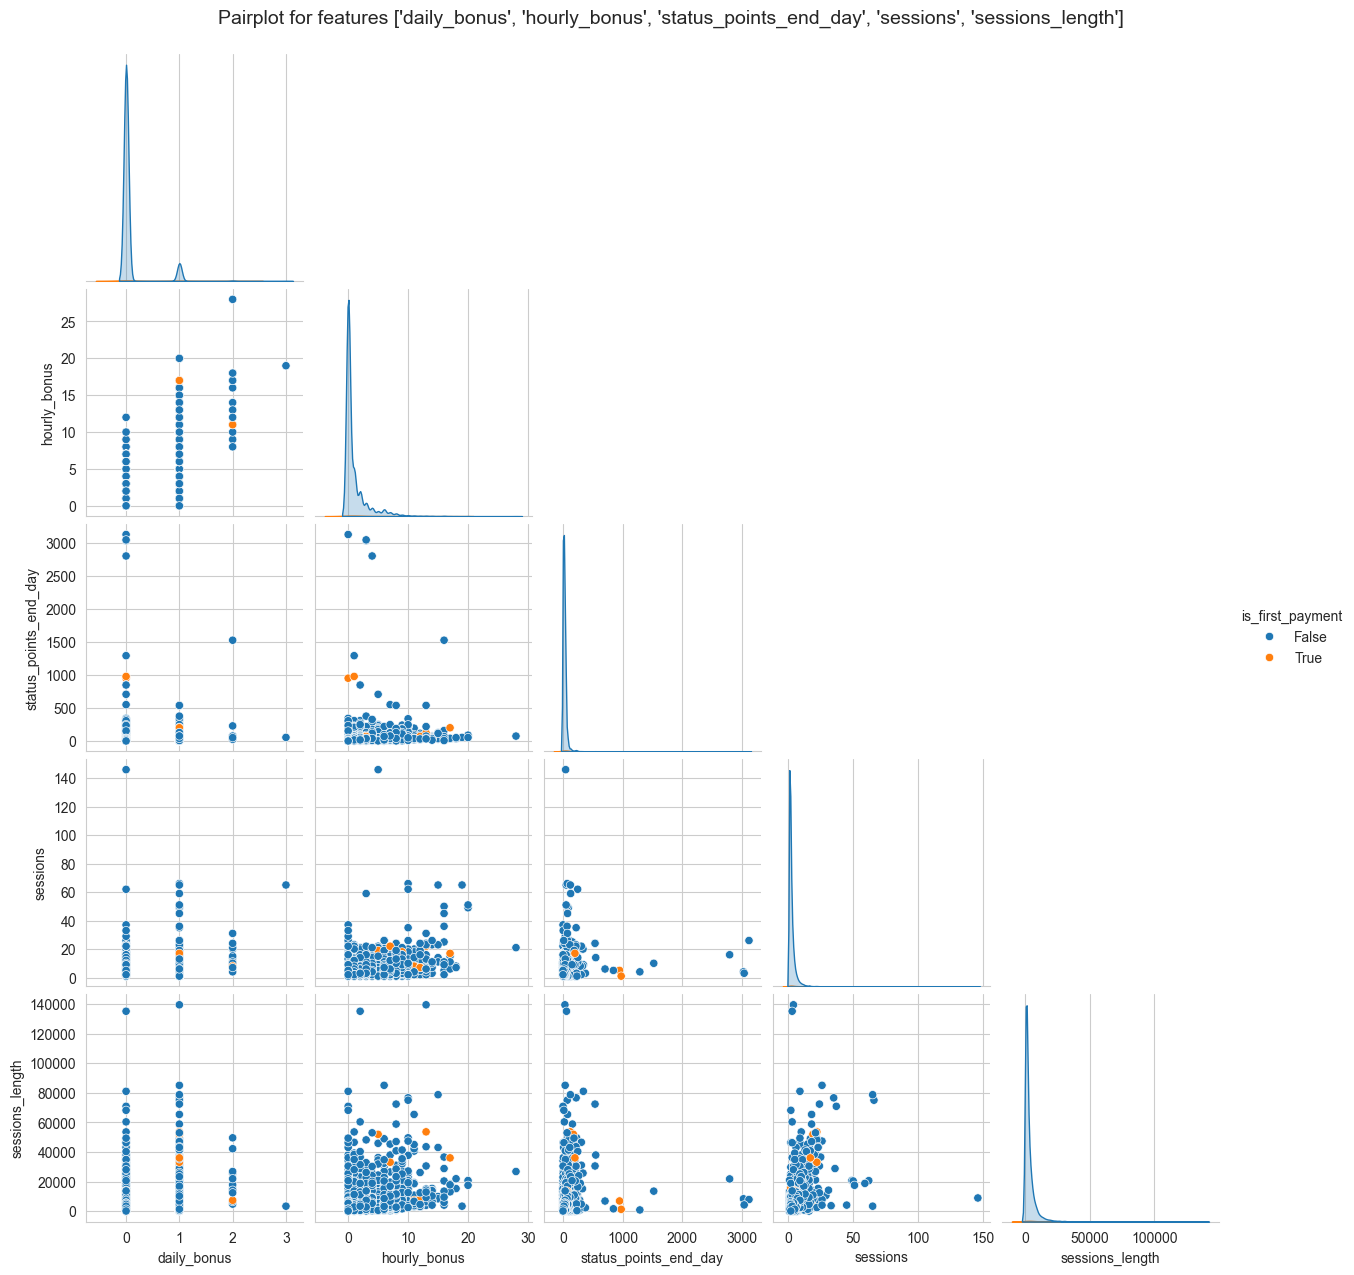

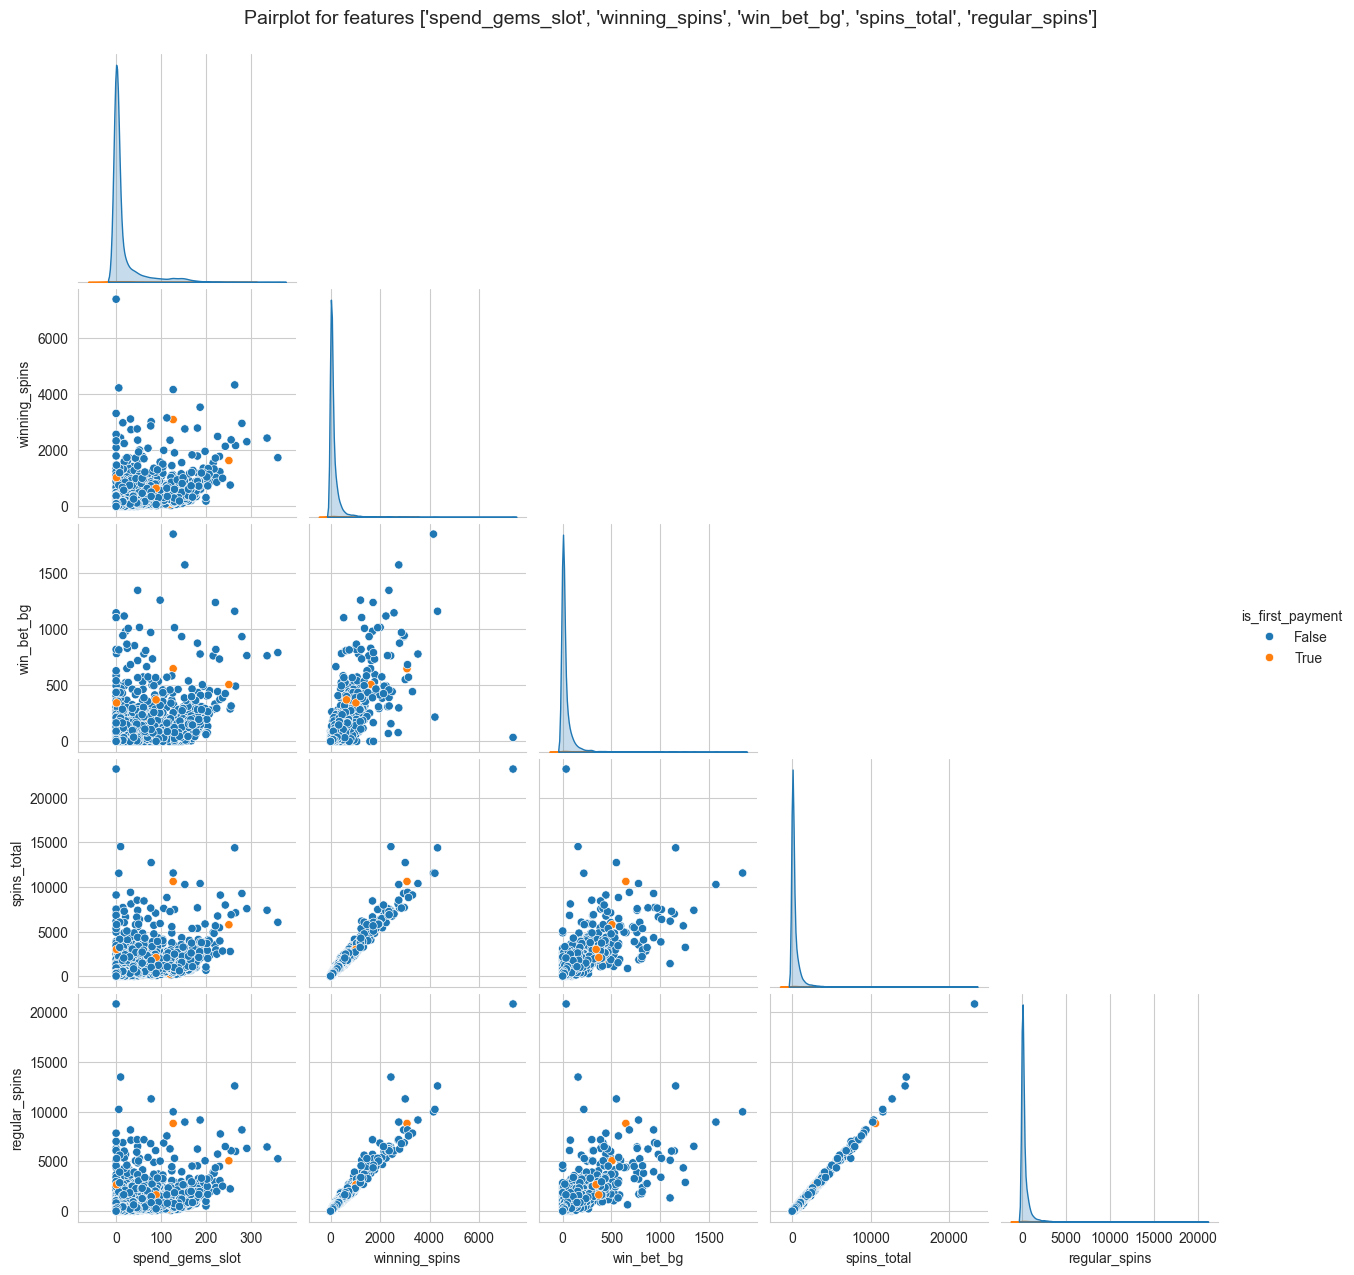

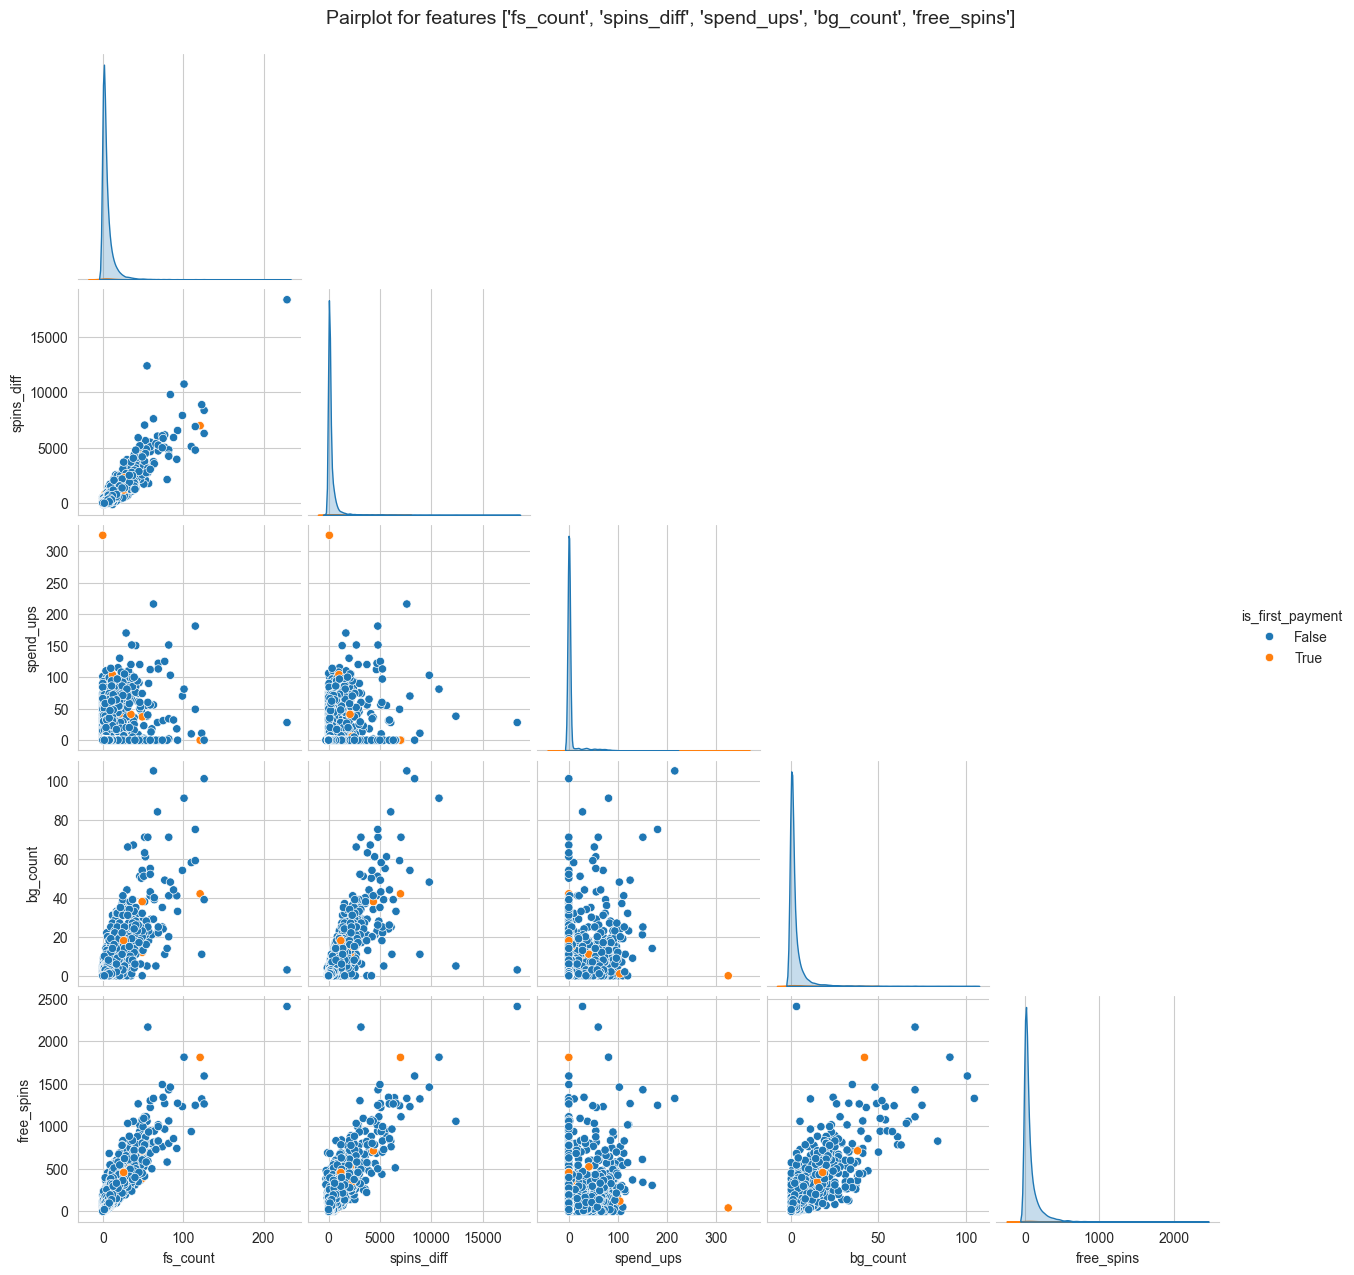

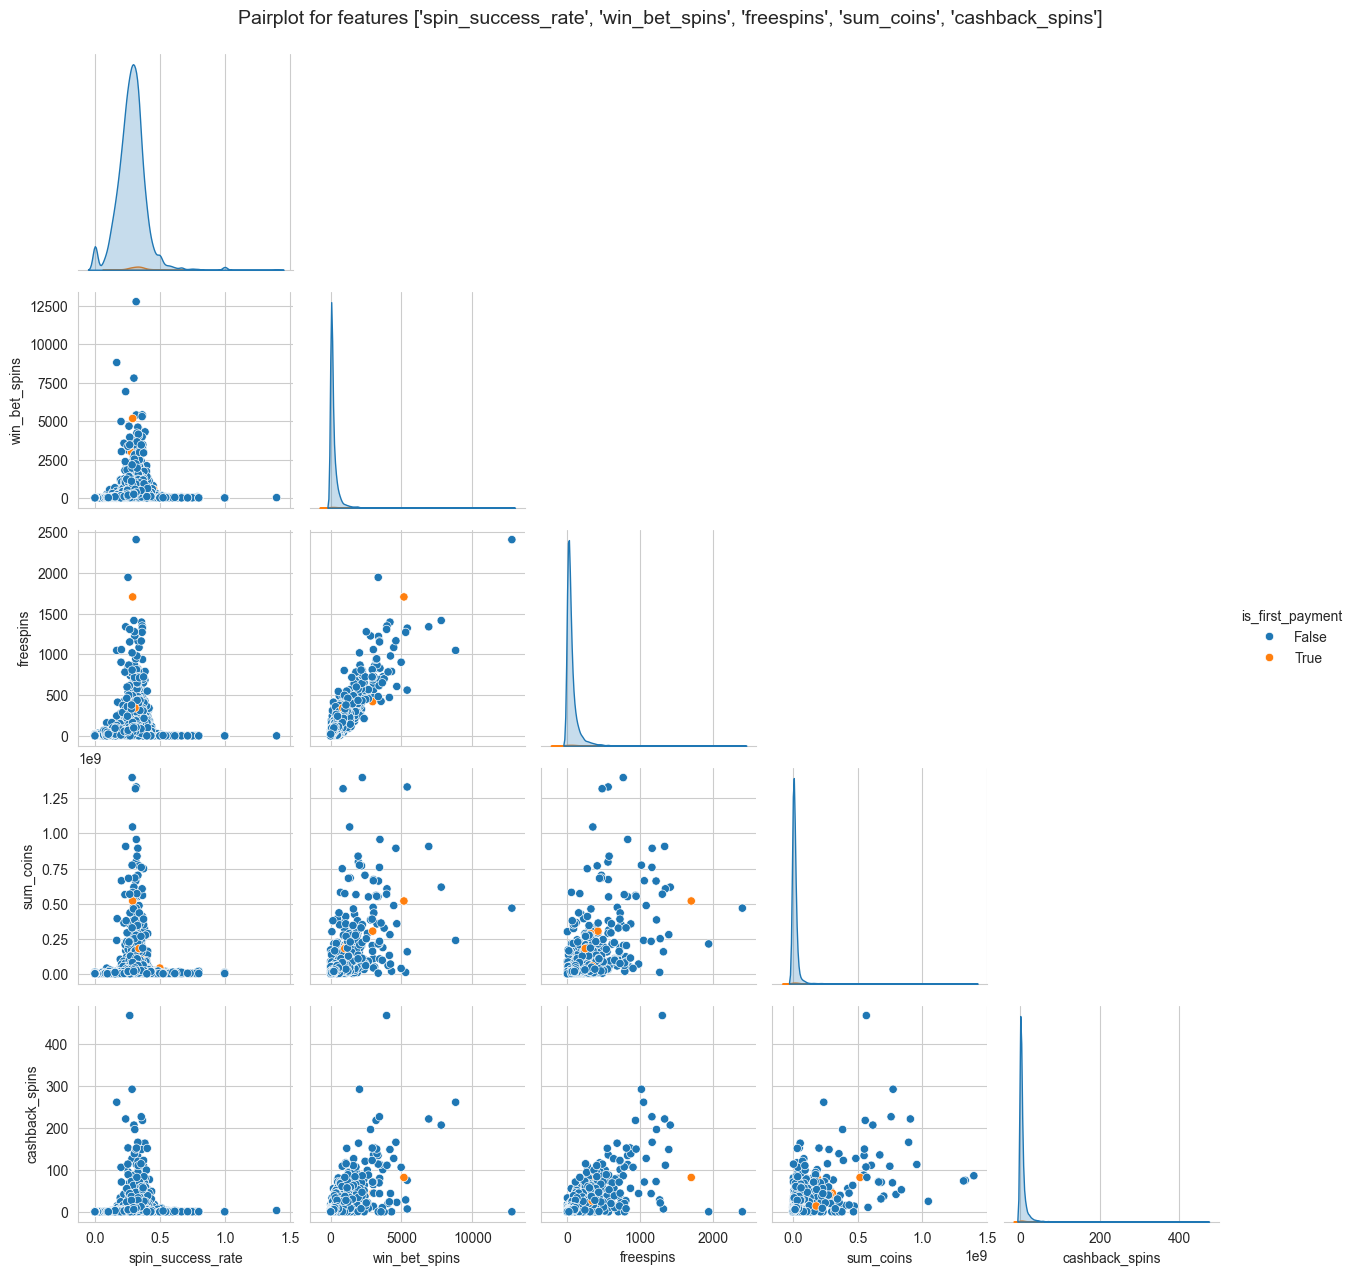

In [19]:
top_features = select_top_correlated_features(
    df_pandas, target_col="is_first_payment", n_features=20
)
print("Top correlated features:", top_features)

create_pairplots_in_chunks(
    df_pandas, feature_cols=top_features, chunk_size=5, hue="is_first_payment"
)

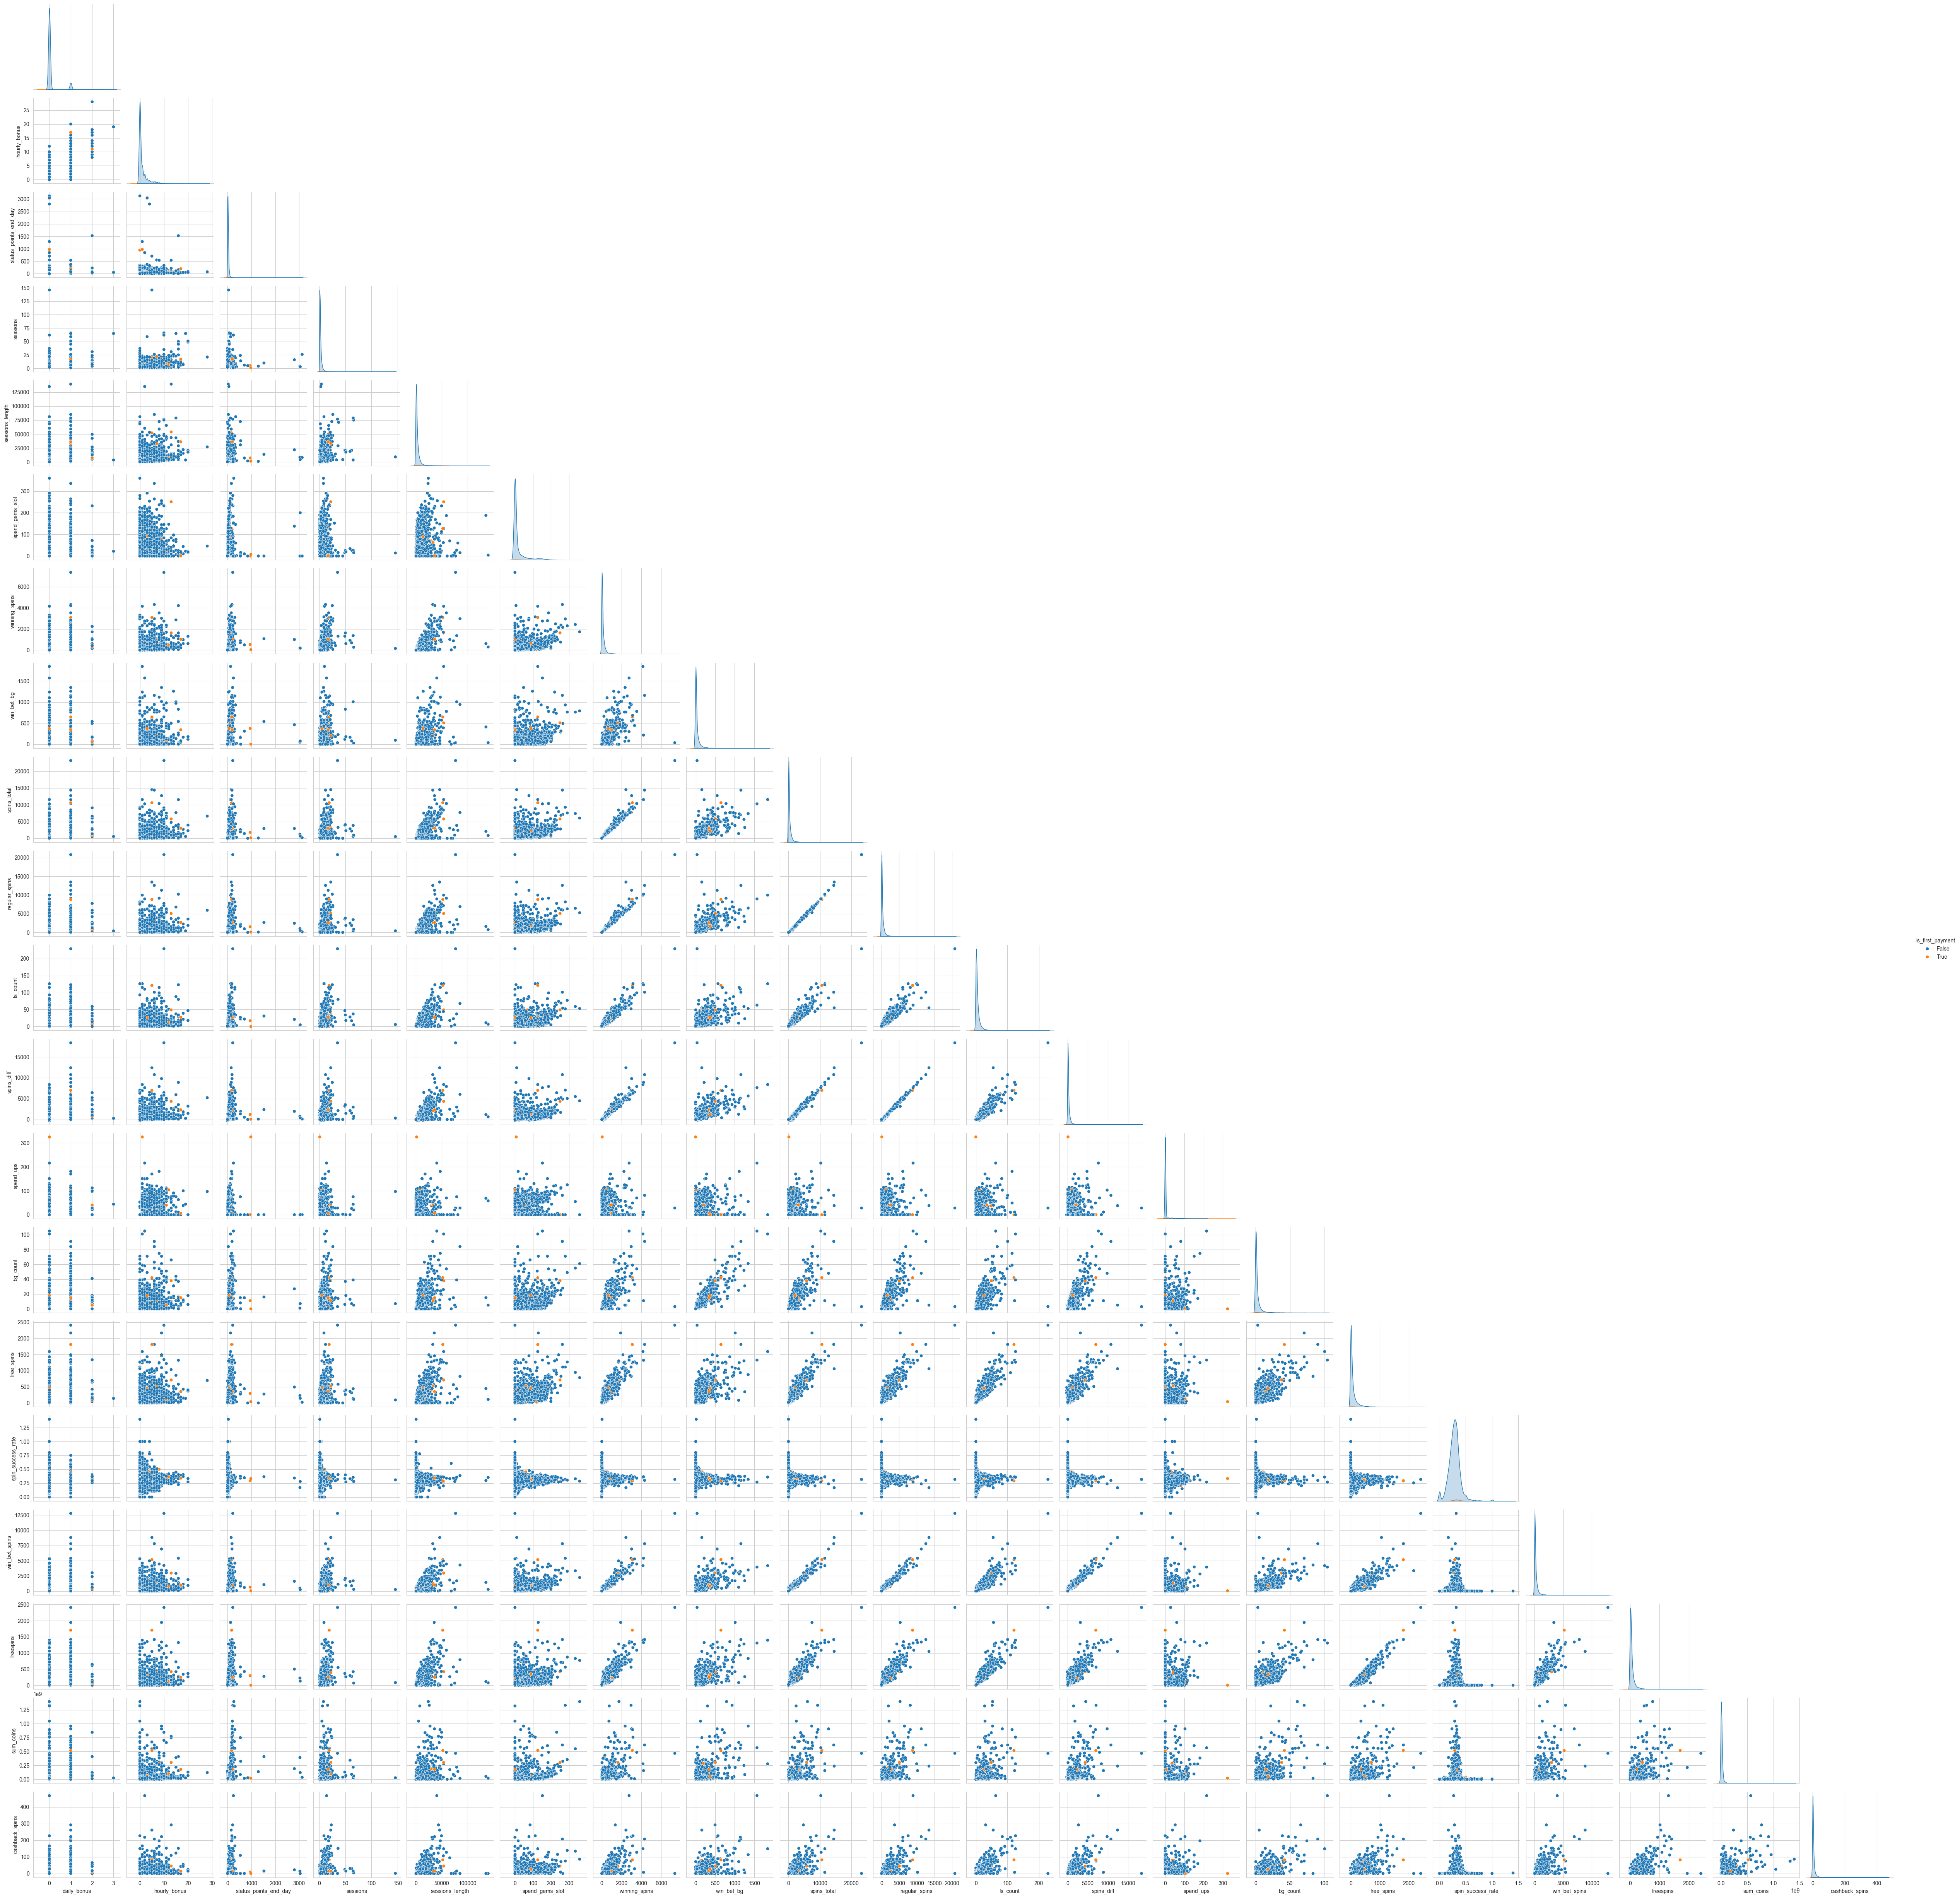

In [20]:
sns.pairplot(
    df_pandas[top_features + ["is_first_payment"]], hue="is_first_payment", corner=True
)

Remove outliers

In [21]:
def get_outliers(
    data: pd.DataFrame, quantile: float = 0.95, columns: list[str] | None = None
) -> pd.Index:
    """
    Get indices of rows where at least one specified column exceeds its chosen quantile.

    Parameters
    ----------
    data : pd.DataFrame
        The original DataFrame.
    quantile : float
        Quantile value to find above outliers.
    columns : list of str, optional
        Columns for which we check the chosen quantile cutoff.
        If None, all numeric columns are used.

    Returns
    -------
    pd.Index
        The index labels of rows that exceed the chosen quantile
        in at least one column.
    """

    if columns is None:
        columns = data.select_dtypes(include=["number"]).columns.tolist()

    quantiles = data[columns].quantile(quantile)
    mask_exceeds = (data[columns] > quantiles).any(axis=1)
    return data[mask_exceeds].index

In [22]:
# df_pandas.shape

In [23]:
# df_pandas = df.select(pl.all().exclude(to_exclude)).to_pandas()

In [24]:
# outliers_indices = get_outliers(df_pandas, quantile=0.99)

In [25]:
# outliers_id = (
#     df.with_row_index()
#     .filter(pl.col("index").is_in(outliers_indices))
#     .select("progress_id")
#     .unique()
# )

In [26]:
# df = df.filter(~pl.col("progress_id").is_in(outliers_id))

In [27]:
# df.shape

In [28]:
# df_pandas = df.select(pl.all().exclude(to_exclude)).to_pandas().sample(10000)

In [29]:
# sns.pairplot(
#     df_pandas[top_features + ["is_first_payment"]], hue="is_first_payment", corner=True
# )

In [30]:
# other_features = df_pandas.columns.difference(top_features)
# sns.pairplot(
#     df_pandas[other_features], hue="is_first_payment", corner=True
# )

Drop useless features

In [31]:
df = df.drop(["jp_fix_mult"])

Generate new features

In [32]:
cat_features = ["country_install", "source", "daily_bonus", "jp_count", "hourly_bonus"]

In [33]:
df.head()

shape: (5, 52)
┌───────────┬───────────┬───────────┬──────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ progress_ ┆ action_da ┆ entry_dat ┆ sessions ┆ … ┆ net_win_j ┆ spin_succ ┆ spins_dif ┆ spend_coi │
│ id        ┆ te        ┆ e         ┆ ---      ┆   ┆ p         ┆ ess_rate  ┆ f         ┆ ns_per_se │
│ ---       ┆ ---       ┆ ---       ┆ i64      ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ssion     │
│ str       ┆ datetime[ ┆ datetime[ ┆          ┆   ┆ f64       ┆ f64       ┆ i64       ┆ ---       │
│           ┆ μs, UTC]  ┆ μs, UTC]  ┆          ┆   ┆           ┆           ┆           ┆ f64       │
╞═══════════╪═══════════╪═══════════╪══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 5996422dd ┆ 2023-04-0 ┆ 2023-03-2 ┆ 23       ┆ … ┆ 3.7417e9  ┆ 0.292616  ┆ 6011      ┆ 2.5537e9  │
│ 72a657f83 ┆ 1         ┆ 8         ┆          ┆   ┆           ┆           ┆           ┆           │
│ 82c0668af ┆ 00:00:00  ┆ 00:00:00  ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆ UTC       ┆ UTC       ┆          ┆   ┆           ┆           ┆           ┆           │
│ 343641c68 ┆ 2023-03-2 ┆ 2023-03-2 ┆ 14       ┆ … ┆ 3.4979e10 ┆ 0.297651  ┆ 8840      ┆ 1.6857e10 │
│ 435d3b963 ┆ 4         ┆ 3         ┆          ┆   ┆           ┆           ┆           ┆           │
│ 1c8034dd0 ┆ 00:00:00  ┆ 00:00:00  ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆ UTC       ┆ UTC       ┆          ┆   ┆           ┆           ┆           ┆           │
│ 489641c8c ┆ 2023-03-2 ┆ 2023-03-2 ┆ 14       ┆ … ┆ 0.0       ┆ 0.236078  ┆ 8151      ┆ 4.9221e7  │
│ eb220f936 ┆ 9         ┆ 3         ┆          ┆   ┆           ┆           ┆           ┆           │
│ e2f0559b9 ┆ 00:00:00  ┆ 00:00:00  ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆ UTC       ┆ UTC       ┆          ┆   ┆           ┆           ┆           ┆           │
│ 075642287 ┆ 2023-03-2 ┆ 2023-03-2 ┆ 16       ┆ … ┆ 1.4701e9  ┆ 0.290712  ┆ 15222     ┆ 3.0929e9  │
│ 51e8fb666 ┆ 9         ┆ 8         ┆          ┆   ┆           ┆           ┆           ┆           │
│ 2500657c1 ┆ 00:00:00  ┆ 00:00:00  ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆ UTC       ┆ UTC       ┆          ┆   ┆           ┆           ┆           ┆           │
│ 1466421c6 ┆ 2023-03-3 ┆ 2023-03-2 ┆ 20       ┆ … ┆ 0.0       ┆ 0.233483  ┆ 7801      ┆ 4.90605e8 │
│ dbda72929 ┆ 0         ┆ 7         ┆          ┆   ┆           ┆           ┆           ┆           │
│ aa70a6e15 ┆ 00:00:00  ┆ 00:00:00  ┆          ┆   ┆           ┆           ┆           ┆           │
│           ┆ UTC       ┆ UTC       ┆          ┆   ┆           ┆           ┆           ┆           │
└───────────┴───────────┴───────────┴──────────┴───┴───────────┴───────────┴───────────┴───────────┘

In [34]:
df.shape

(165508, 52)

In [35]:
# Exclude specific columns
to_exclude = [
    "action_date",
    "entry_date",
    "progress_id",
    "is_first_payment"
]

to_exclude.extend(cat_features)

# Group by 'progress_id' and aggregate multiple statistics
# Aggregation operations with suffixes
aggregations = [
    ("_mean", lambda col: pl.col(col).mean()),
    ("_median", lambda col: pl.col(col).median()),
    ("_std", lambda col: pl.col(col).std()),
    ("_max", lambda col: pl.col(col).max()),
    ("_min", lambda col: pl.col(col).min()),
    ("_sum", lambda col: pl.col(col).sum()),
]

# Apply groupby and dynamic aggregations
df_agg = df.group_by("progress_id").agg(
    [
        agg_func(col).alias(f"{col}{suffix}")
        for suffix, agg_func in aggregations
        for col in df.columns
        if col not in to_exclude
    ]
)

In [36]:
df_agg.head()

shape: (5, 259)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ progress_ ┆ sessions_ ┆ sessions_ ┆ level_mea ┆ … ┆ net_win_j ┆ spin_succ ┆ spins_dif ┆ spend_co │
│ id        ┆ mean      ┆ length_me ┆ n         ┆   ┆ p_sum     ┆ ess_rate_ ┆ f_sum     ┆ ins_per_ │
│ ---       ┆ ---       ┆ an        ┆ ---       ┆   ┆ ---       ┆ sum       ┆ ---       ┆ session_ │
│ str       ┆ f64       ┆ ---       ┆ f64       ┆   ┆ f64       ┆ ---       ┆ i64       ┆ sum      │
│           ┆           ┆ f64       ┆           ┆   ┆           ┆ f64       ┆           ┆ ---      │
│           ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆ f64      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 85064248d ┆ 1.0       ┆ 1238.0    ┆ 7.0       ┆ … ┆ 0.0       ┆ 0.266187  ┆ 97        ┆ 1.74e7   │
│ 80fac6e33 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 8c20d8e8f ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 053641b31 ┆ 1.0       ┆ 713.0     ┆ 4.5       ┆ … ┆ 0.0       ┆ 0.514719  ┆ 73        ┆ 3.01e7   │
│ fefed771f ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 8ec068e91 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 032641d33 ┆ 1.0       ┆ 256.5     ┆ 1.0       ┆ … ┆ 0.0       ┆ 0.34359   ┆ 23        ┆ 1.44e6   │
│ 36a862ada ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 0400e0e99 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 176641d10 ┆ 1.0       ┆ 1107.0    ┆ 8.0       ┆ … ┆ 0.0       ┆ 0.264901  ┆ 53        ┆ 1.723e7  │
│ c5e22a04a ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 25a0ef191 ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 23964171a ┆ 1.0       ┆ 1595.0    ┆ 15.0      ┆ … ┆ 3.0875e6  ┆ 0.335697  ┆ 239       ┆ 8.1215e8 │
│ 3a79d2d7e ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ 20a095e2b ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘

In [37]:
is_first_payment_df = df.group_by("progress_id").agg(
    pl.col("is_first_payment").any().alias("is_first_payment")
)

cat_features_df = df.group_by("progress_id").agg(pl.col(cat_features).mode().first())

In [38]:
df_agg = df_agg.join(is_first_payment_df, on="progress_id")
df_agg = df_agg.join(cat_features_df, on="progress_id")

In [39]:
missing_df = (
    df_agg.null_count()
    .transpose(include_header=True)
    .rename({"column_0": "Null Values"})
    .with_columns((pl.col("Null Values") / df.shape[0] * 100).alias("Null%"))
    .sort("Null Values", descending=True)
)

missing_df

shape: (265, 3)
┌─────────────────────────────┬─────────────┬───────────┐
│ column                      ┆ Null Values ┆ Null%     │
│ ---                         ┆ ---         ┆ ---       │
│ str                         ┆ u32         ┆ f64       │
╞═════════════════════════════╪═════════════╪═══════════╡
│ total_win_bg_std            ┆ 70942       ┆ 42.863185 │
│ total_win_fs_std            ┆ 70942       ┆ 42.863185 │
│ total_win_std               ┆ 70942       ┆ 42.863185 │
│ max_bet_std                 ┆ 70942       ┆ 42.863185 │
│ total_win_jp_std            ┆ 70942       ┆ 42.863185 │
│ …                           ┆ …           ┆ …         │
│ spend_coins_per_session_sum ┆ 0           ┆ 0.0       │
│ is_first_payment            ┆ 0           ┆ 0.0       │
│ source                      ┆ 0           ┆ 0.0       │
│ daily_bonus                 ┆ 0           ┆ 0.0       │
│ hourly_bonus                ┆ 0           ┆ 0.0       │
└─────────────────────────────┴─────────────┴───────────┘

In [40]:
df_agg = df_agg.with_columns(
    (pl.col("is_first_payment").cast(pl.Int8)).alias("is_first_payment")
)

Imbalanced classification problem

In [41]:
df_agg.group_by("is_first_payment").len()

shape: (2, 2)
┌──────────────────┬───────┐
│ is_first_payment ┆ len   │
│ ---              ┆ ---   │
│ i8               ┆ u32   │
╞══════════════════╪═══════╡
│ 0                ┆ 98184 │
│ 1                ┆ 555   │
└──────────────────┴───────┘

Split data

In [42]:
to_exclude = [
    "progress_id",
    "action_date",
    "entry_date",
    "is_first_payment",
]

to_exclude.extend(cat_features)
X = df_agg.select(pl.all().exclude(to_exclude)).to_pandas()

In [43]:
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna(axis=1, how="all")
y = df_agg.select("is_first_payment").to_pandas()

In [44]:
X_train, X_val, X_test, y_train, y_val, y_test = split_data(
    X, y, val_size=0.1, test_size=0.2, use_stratification=True, random_state=42
)

In [45]:
imputer = SimpleImputer(strategy="median")
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)

In [46]:
X_val = X_val.replace([np.inf, -np.inf], np.nan)
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

X_test = X_test.replace([np.inf, -np.inf], np.nan)
X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns)

In [47]:
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

In [48]:
X_train.stb.missing()

missing  total  percent
sessions_mean                      0  69117      0.0
total_win_jp_min                   0  69117      0.0
ratio_free_spins_max               0  69117      0.0
net_coins_max                      0  69117      0.0
total_gems_spent_max               0  69117      0.0
...                              ...    ...      ...
free_spins_std                     0  69117      0.0
coins_start_day_std                0  69117      0.0
coins_end_day_std                  0  69117      0.0
spend_coins_std                    0  69117      0.0
spend_coins_per_session_sum        0  69117      0.0

[258 rows x 3 columns]

In [49]:
X_val.stb.missing()

missing  total  percent
sessions_mean                      0   9874      0.0
total_win_jp_min                   0   9874      0.0
ratio_free_spins_max               0   9874      0.0
net_coins_max                      0   9874      0.0
total_gems_spent_max               0   9874      0.0
...                              ...    ...      ...
free_spins_std                     0   9874      0.0
coins_start_day_std                0   9874      0.0
coins_end_day_std                  0   9874      0.0
spend_coins_std                    0   9874      0.0
spend_coins_per_session_sum        0   9874      0.0

[258 rows x 3 columns]

In [50]:
X_test.stb.missing()

missing  total  percent
sessions_mean                      0  19748      0.0
total_win_jp_min                   0  19748      0.0
ratio_free_spins_max               0  19748      0.0
net_coins_max                      0  19748      0.0
total_gems_spent_max               0  19748      0.0
...                              ...    ...      ...
free_spins_std                     0  19748      0.0
coins_start_day_std                0  19748      0.0
coins_end_day_std                  0  19748      0.0
spend_coins_std                    0  19748      0.0
spend_coins_per_session_sum        0  19748      0.0

[258 rows x 3 columns]

In [51]:
y_train.stb.freq(["is_first_payment"])

is_first_payment  count    percent  cumulative_count  cumulative_percent
0                 0  68729  99.438633             68729           99.438633
1                 1    388   0.561367             69117          100.000000

In [52]:
y_val.stb.freq(["is_first_payment"])

is_first_payment  count    percent  cumulative_count  cumulative_percent
0                 0   9818  99.432854              9818           99.432854
1                 1     56   0.567146              9874          100.000000

In [53]:
y_test.stb.freq(["is_first_payment"])

is_first_payment  count    percent  cumulative_count  cumulative_percent
0                 0  19637  99.437918             19637           99.437918
1                 1    111   0.562082             19748          100.000000

Hyperparameter tuning

In [54]:
def optimize_catboost(
    X: pd.DataFrame,
    y: pd.Series,
    n_splits: int = 5,
    n_repeats: int = 3,
    n_trials: int = 50,
    random_state: int = 42,
    max_iterations: int = 1000,
    optimize_metric: Literal["F1", "Recall"] = "F1",
) -> Tuple[optuna.Study, Dict[str, Any], pd.DataFrame]:
    """
    Optimize CatBoost hyperparameters for imbalanced classification using SMOTEENN
    and RepeatedStratifiedKFold, measuring either the Recall or the F1-score for
    the positive class (class 1). Then, with the best hyperparameters found, run
    a custom cross-validation to collect iteration-wise metrics (F1/Recall + Logloss)
    across folds, returning a table similar to catboost.cv output.

    Parameters
    ----------
    X : pd.DataFrame
        The feature matrix.
    y : pd.Series
        The target vector with imbalanced classes (binary, with 0 and 1).
    n_splits : int, optional
        Number of folds for Stratified K-Fold, by default 5.
    n_repeats : int, optional
        Number of repetitions for RepeatedStratifiedKFold, by default 3.
    n_trials : int, optional
        Number of trials for the Optuna study, by default 50.
    random_state : int, optional
        Random seed for reproducibility, by default 42.
    max_iterations : int, optional
        The maximum number of boosting iterations to use (like in catboost.cv),
        by default 1000.
    optimize_metric : {"F1", "Recall"}, optional
        Which metric to optimize for class 1, by default "F1".

    Returns
    -------
    Tuple[optuna.Study, Dict[str, Any], pd.DataFrame]
        A tuple containing:
        - study : optuna.Study
            The Optuna study object after completion of trials.
        - best_params : Dict[str, Any]
            The best set of hyperparameters found.
        - cv_results : pd.DataFrame
            A DataFrame containing iteration-wise means and standard deviations
            for training/validation metrics (F1 or Recall, and Logloss), aggregated
            over all folds. Columns are similar to catboost.cv output.
    """
    import warnings

    warnings.filterwarnings("ignore", category=UserWarning)

    # Decide which metric is the "main" one for CatBoost and for our manual scoring
    if optimize_metric not in ["F1", "Recall"]:
        raise ValueError("optimize_metric must be either 'F1' or 'Recall'.")

    # 1) Define the Optuna objective function using cross-validation
    def objective(trial: optuna.Trial) -> float:
        """
        Returns mean chosen_metric (pos_label=1) over all folds (to be maximized).
        """
        # CatBoost will watch 'eval_metric' for each iteration
        params = {
            "loss_function": "Logloss",
            "eval_metric": optimize_metric,  # Evaluate "F1" or "Recall" on validation
            "custom_metric": ["Logloss"],
            "iterations": max_iterations,
            "use_best_model": False,  # do not stop early
            "metric_period": 1,  # log metric at every iteration
            "depth": trial.suggest_int("depth", 3, 12),
            "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
            "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 100, log=True),
            "random_strength": trial.suggest_float(
                "random_strength", 1e-2, 10.0, log=True
            ),
            "border_count": trial.suggest_int("border_count", 32, 256),
            "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 100, log=True),
            "verbose": 0,
            "random_seed": random_state,
            "allow_writing_files": False
        }

        # We'll pick the appropriate scoring function for the fold evaluation
        if optimize_metric == "Recall":
            scoring_func = lambda y_true, y_pred: recall_score(
                y_true, y_pred, pos_label=1
            )
        else:
            scoring_func = lambda y_true, y_pred: f1_score(y_true, y_pred, pos_label=1)

        rskf = RepeatedStratifiedKFold(
            n_splits=n_splits, n_repeats=n_repeats, random_state=random_state
        )

        fold_scores = []
        for train_index, val_index in rskf.split(X, y):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            # Apply SMOTEENN on training fold
            sampler = SMOTEENN(random_state=random_state)
            X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)

            # Train
            model = CatBoostClassifier(**params)
            model.fit(X_resampled, y_resampled, eval_set=(X_val, y_val))

            # Predict on validation fold
            y_pred = model.predict(X_val)

            # Compute chosen metric for class 1
            fold_scores.append(scoring_func(y_val, y_pred))

        return float(np.mean(fold_scores))

    # 2) Run Optuna study
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)

    best_params = study.best_trial.params

    # Merge fixed params back in
    fixed_params = {
        "loss_function": "Logloss",
        "eval_metric": optimize_metric,  # same as chosen above
        "custom_metric": ["Logloss"],
        "iterations": max_iterations,
        "use_best_model": False,
        "metric_period": 1,
        "verbose": 0,
        "random_seed": random_state,
        "allow_writing_files": False,
    }
    for k, v in fixed_params.items():
        best_params[k] = v

    # 3) Final cross-validation pass to gather iteration-wise metrics
    def cross_val_iterations(
        X: pd.DataFrame,
        y: pd.Series,
        params: Dict[str, Any],
        n_splits: int,
        n_repeats: int,
        random_state: int,
        main_metric: str,
    ) -> pd.DataFrame:
        """
        Run repeated CV for a fixed set of CatBoost parameters, capturing
        iteration-wise metrics (F1/Recall + Logloss) for each fold, then averaging.

        Returns a DataFrame with columns similar to catboost.cv:
            iteration,
            train-{main_metric}-mean, train-{main_metric}-std,
            test-{main_metric}-mean,  test-{main_metric}-std,
            train-Logloss-mean,       train-Logloss-std,
            test-Logloss-mean,        test-Logloss-std
        """
        rskf = RepeatedStratifiedKFold(
            n_splits=n_splits, n_repeats=n_repeats, random_state=random_state
        )

        train_metric_folds = []
        test_metric_folds = []
        train_logloss_folds = []
        test_logloss_folds = []

        for train_index, val_index in rskf.split(X, y):
            X_train, X_val = X.iloc[train_index], X.iloc[val_index]
            y_train, y_val = y.iloc[train_index], y.iloc[val_index]

            sampler = SMOTEENN(random_state=random_state)
            X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)

            model = CatBoostClassifier(**params)
            model.fit(X_resampled, y_resampled, eval_set=(X_val, y_val))

            results = model.get_evals_result()
            train_key, test_key = "learn", "validation"
            if test_key not in results:
                # older catboost versions might store "eval"
                test_key = "eval"

            # The main metric might be "F1" or "Recall", custom metric is "Logloss"
            # Example: results["learn"]["F1"] or results["learn"]["Recall"]
            train_metric_folds.append(results[train_key][main_metric])
            test_metric_folds.append(results[test_key][main_metric])

            # If "Logloss" not found, fallback to "TotalLoss"
            if "Logloss" in results[train_key]:
                train_logloss_folds.append(results[train_key]["Logloss"])
                test_logloss_folds.append(results[test_key]["Logloss"])
            else:
                train_logloss_folds.append(results[train_key]["TotalLoss"])
                test_logloss_folds.append(results[test_key]["TotalLoss"])

        # Convert to arrays of shape (num_folds, num_iterations)
        train_metric_folds = np.array(train_metric_folds, dtype=object)
        test_metric_folds = np.array(test_metric_folds, dtype=object)
        train_logloss_folds = np.array(train_logloss_folds, dtype=object)
        test_logloss_folds = np.array(test_logloss_folds, dtype=object)

        n_iters = len(train_metric_folds[0])  # should match 'iterations'

        data = []
        for i in range(n_iters):
            # Gather iteration i across all folds
            train_metric_values = [fold[i] for fold in train_metric_folds]
            test_metric_values = [fold[i] for fold in test_metric_folds]
            train_logloss_values = [fold[i] for fold in train_logloss_folds]
            test_logloss_values = [fold[i] for fold in test_logloss_folds]

            data.append(
                {
                    "iteration": i + 1,  # 1-based
                    f"train-{main_metric}-mean": np.mean(train_metric_values),
                    f"train-{main_metric}-std": np.std(train_metric_values, ddof=1),
                    f"test-{main_metric}-mean": np.mean(test_metric_values),
                    f"test-{main_metric}-std": np.std(test_metric_values, ddof=1),
                    "train-Logloss-mean": np.mean(train_logloss_values),
                    "train-Logloss-std": np.std(train_logloss_values, ddof=1),
                    "test-Logloss-mean": np.mean(test_logloss_values),
                    "test-Logloss-std": np.std(test_logloss_values, ddof=1),
                }
            )

        return pd.DataFrame(data)

    cv_results = cross_val_iterations(
        X, y, best_params, n_splits, n_repeats, random_state, optimize_metric
    )

    return study, best_params, cv_results

In [55]:
# Optimize and retrieve iteration-wise CV results
study_obj, best_params, cv_table = optimize_catboost(
    X_train_full,
    y_train_full,
    optimize_metric="F1",
    n_splits=3,
    n_repeats=3,
    n_trials=20,
    random_state=42,
    max_iterations=2000,
)

[I 2025-01-23 04:17:17,619] A new study created in memory with name: no-name-77e37345-2afe-4128-b09b-c866276fd04f
[I 2025-01-23 04:57:26,009] Trial 0 finished with value: 0.02971769136168568 and parameters: {'depth': 11, 'learning_rate': 0.03880131170614269, 'l2_leaf_reg': 27, 'random_strength': 0.14889558384590235, 'border_count': 144, 'scale_pos_weight': 9}. Best is trial 0 with value: 0.02971769136168568.
[I 2025-01-23 05:37:24,855] Trial 1 finished with value: 0.027929535112222324 and parameters: {'depth': 11, 'learning_rate': 0.009312084690077311, 'l2_leaf_reg': 1, 'random_strength': 0.05951226201600454, 'border_count': 135, 'scale_pos_weight': 6}. Best is trial 0 with value: 0.02971769136168568.
[I 2025-01-23 05:44:59,674] Trial 2 finished with value: 0.026638989246606785 and parameters: {'depth': 5, 'learning_rate': 0.013892191082909035, 'l2_leaf_reg': 2, 'random_strength': 0.012669305974494427, 'border_count': 119, 'scale_pos_weight': 20}. Best is trial 0 with value: 0.02971769

In [56]:
cv_table

iteration  train-F1-mean  train-F1-std  test-F1-mean  test-F1-std  \
0             1       0.854787      0.009612      0.036191     0.004556   
1             2       0.873336      0.008877      0.039085     0.003692   
2             3       0.879103      0.010618      0.039153     0.003556   
3             4       0.887282      0.010815      0.040581     0.003285   
4             5       0.888559      0.009815      0.041489     0.003484   
...         ...            ...           ...           ...          ...   
1995       1996       0.954147      0.002198      0.060895     0.006601   
1996       1997       0.954169      0.002206      0.060909     0.006619   
1997       1998       0.954173      0.002206      0.060925     0.006615   
1998       1999       0.954191      0.002220      0.060813     0.006626   
1999       2000       0.954201      0.002211      0.060831     0.006635   

      train-Logloss-mean  train-Logloss-std  test-Logloss-mean  \
0               0.691884           0.000141           0.692236   
1               0.690784           0.000232           0.691432   
2               0.689826           0.000364           0.690684   
3               0.688669           0.000424           0.689894   
4               0.687467           0.000570           0.689014   
...                  ...                ...                ...   
1995            0.180925           0.004558           0.227415   
1996            0.180878           0.004564           0.227358   
1997            0.180824           0.004556           0.227298   
1998            0.180780           0.004554           0.227241   
1999            0.180727           0.004547           0.227191   

      test-Logloss-std  
0             0.000059  
1             0.000137  
2             0.000121  
3             0.000126  
4             0.000147  
...                ...  
1995          0.008448  
1996          0.008453  
1997          0.008459  
1998          0.008464  
1999          0.008465  

[2000 rows x 9 columns]

In [57]:
# Print results
print("Best F1:", study_obj.best_value)

best_params["iterations"] = cv_table["test-F1-mean"].idxmax()
print("Best parameters:", best_params)

Best F1: 0.06083111096956522
Best parameters: {'depth': 8, 'learning_rate': 0.001151837916126496, 'l2_leaf_reg': 3, 'random_strength': 2.2415942777205395, 'border_count': 98, 'scale_pos_weight': 1, 'loss_function': 'Logloss', 'eval_metric': 'F1', 'custom_metric': ['Logloss'], 'iterations': 1997, 'use_best_model': False, 'metric_period': 1, 'verbose': 0, 'random_seed': 42, 'allow_writing_files': False}


In [58]:
model = Pipeline(
    [
        (
            "smoteenn",
            SMOTEENN(random_state=42),
        ),
        (
            "catboost",
            CatBoostClassifier(
                loss_function="Logloss",
                iterations=best_params["iterations"],
                depth=best_params["depth"],
                learning_rate=best_params["learning_rate"],
                l2_leaf_reg=best_params["l2_leaf_reg"],
                random_strength=best_params["random_strength"],
                border_count=best_params["border_count"],
                scale_pos_weight=best_params["scale_pos_weight"],
                random_seed=42,
            ),
        ),
    ]
)

In [59]:
model.fit(X_train_full, y_train_full)

0:	learn: 0.6920298	total: 46.8ms	remaining: 1m 33s
1:	learn: 0.6908821	total: 88.5ms	remaining: 1m 28s
2:	learn: 0.6896964	total: 133ms	remaining: 1m 28s
3:	learn: 0.6886263	total: 175ms	remaining: 1m 27s
4:	learn: 0.6873536	total: 218ms	remaining: 1m 26s
5:	learn: 0.6860991	total: 259ms	remaining: 1m 25s
6:	learn: 0.6850056	total: 307ms	remaining: 1m 27s
7:	learn: 0.6836391	total: 352ms	remaining: 1m 27s
8:	learn: 0.6828365	total: 389ms	remaining: 1m 25s
9:	learn: 0.6818142	total: 429ms	remaining: 1m 25s
10:	learn: 0.6804956	total: 470ms	remaining: 1m 24s
11:	learn: 0.6789664	total: 518ms	remaining: 1m 25s
12:	learn: 0.6774782	total: 560ms	remaining: 1m 25s
13:	learn: 0.6765652	total: 604ms	remaining: 1m 25s
14:	learn: 0.6752242	total: 648ms	remaining: 1m 25s
15:	learn: 0.6741838	total: 697ms	remaining: 1m 26s
16:	learn: 0.6730410	total: 738ms	remaining: 1m 26s
17:	learn: 0.6717568	total: 778ms	remaining: 1m 25s
18:	learn: 0.6705858	total: 821ms	remaining: 1m 25s
19:	learn: 0.6695169

Pipeline(steps=[('smoteenn', SMOTEENN(random_state=42)),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x30ad8c2e0>)])

In [60]:
pred = model.predict(X_test)
pred_proba = model.predict_proba(X_test)[:, 1]

In [61]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97     19637
           1       0.04      0.38      0.07       111

    accuracy                           0.94     19748
   macro avg       0.52      0.66      0.52     19748
weighted avg       0.99      0.94      0.96     19748



In [75]:
f1_score(y_test, pred)

0.06222990492653414

In [62]:
confusion_matrix(y_test, pred)

array([[18550,  1087],
       [   69,    42]])

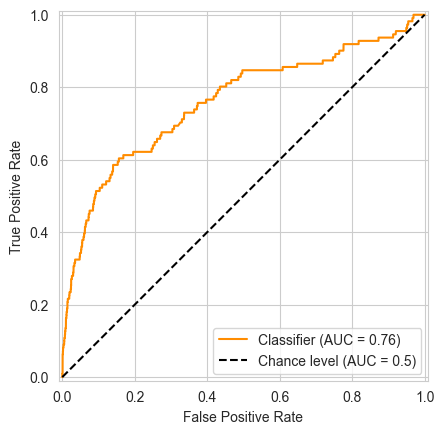

In [63]:
display = RocCurveDisplay.from_predictions(
    y_test,
    pred_proba,
    color="darkorange",
    plot_chance_level=True,
)
_ = display.ax_.set(xlabel="False Positive Rate", ylabel="True Positive Rate")

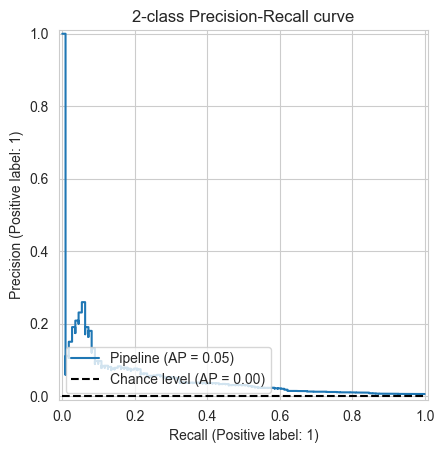

In [64]:
display = PrecisionRecallDisplay.from_estimator(
    model, X_test, y_test, name="Pipeline", plot_chance_level=True
)
_ = display.ax_.set_title("2-class Precision-Recall curve")

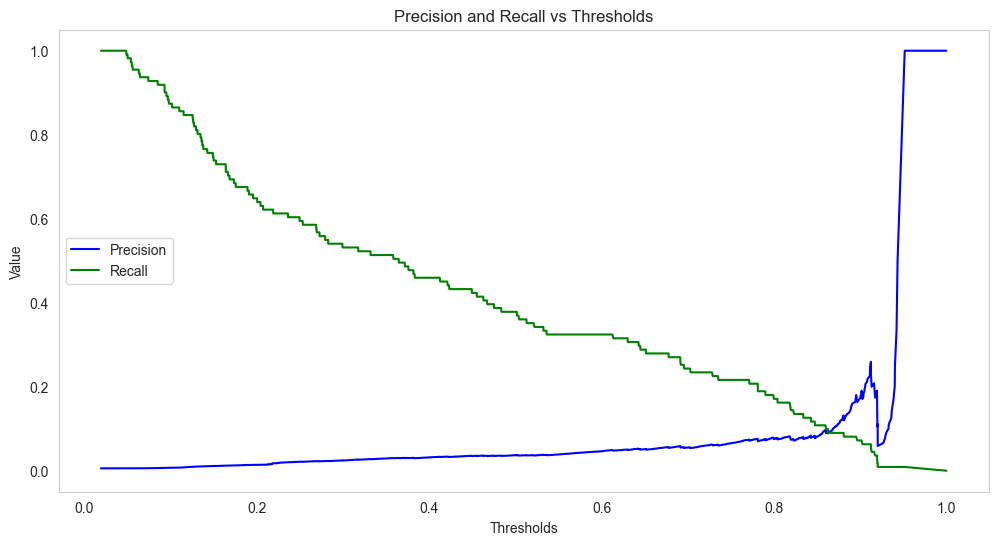

In [65]:
precision, recall, thresholds = precision_recall_curve(y_test, pred_proba)
thresholds = np.append(thresholds, 1.0)

plt.figure(figsize=(12, 6))
plt.plot(thresholds, precision, label="Precision", color="blue")
plt.plot(thresholds, recall, label="Recall", color="green")

plt.xlabel("Thresholds")
plt.ylabel("Value")
plt.title("Precision and Recall vs Thresholds")
plt.legend()
plt.grid()
plt.show()

Fearure selection

In [66]:
model.fit(X_train, y_train)

0:	learn: 0.6918874	total: 44ms	remaining: 1m 27s
1:	learn: 0.6905785	total: 82.9ms	remaining: 1m 22s
2:	learn: 0.6894034	total: 119ms	remaining: 1m 19s
3:	learn: 0.6882125	total: 156ms	remaining: 1m 17s
4:	learn: 0.6869427	total: 193ms	remaining: 1m 16s
5:	learn: 0.6857007	total: 229ms	remaining: 1m 15s
6:	learn: 0.6847864	total: 267ms	remaining: 1m 15s
7:	learn: 0.6833153	total: 308ms	remaining: 1m 16s
8:	learn: 0.6824000	total: 348ms	remaining: 1m 16s
9:	learn: 0.6814327	total: 385ms	remaining: 1m 16s
10:	learn: 0.6801405	total: 422ms	remaining: 1m 16s
11:	learn: 0.6786397	total: 458ms	remaining: 1m 15s
12:	learn: 0.6772025	total: 495ms	remaining: 1m 15s
13:	learn: 0.6761748	total: 530ms	remaining: 1m 15s
14:	learn: 0.6748470	total: 571ms	remaining: 1m 15s
15:	learn: 0.6737278	total: 609ms	remaining: 1m 15s
16:	learn: 0.6727488	total: 648ms	remaining: 1m 15s
17:	learn: 0.6717306	total: 685ms	remaining: 1m 15s
18:	learn: 0.6705030	total: 721ms	remaining: 1m 15s
19:	learn: 0.6694147	t

Pipeline(steps=[('smoteenn', SMOTEENN(random_state=42)),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x30ad8c2e0>)])

In [67]:
classifier = model.named_steps["catboost"]

In [68]:
feature_importance = classifier.get_feature_importance(
    type="LossFunctionChange", data=Pool(X_val, y_val), prettified=True
)

In [69]:
feature_importance

Feature Id  Importances
0                   sessions_max     0.041657
1                   sessions_min     0.036342
2            coins_start_day_min     0.020056
3                   bg_count_max     0.017927
4           spend_gems_other_max     0.016329
..                           ...          ...
253  spend_coins_per_session_max    -0.000689
254              win_bet_bg_mean    -0.000731
255               win_bet_bg_max    -0.000778
256            total_win_bg_mean    -0.000856
257               win_bet_bg_sum    -0.001236

[258 rows x 2 columns]

In [81]:
most_importance_features = feature_importance.loc[:70, "Feature Id"]
most_importance_features

0             sessions_max
1             sessions_min
2      coins_start_day_min
3             bg_count_max
4     spend_gems_other_max
              ...         
66               level_max
67            bg_count_std
68        total_win_bg_min
69      ups_start_day_mean
70           net_coins_max
Name: Feature Id, Length: 71, dtype: object

In [82]:
to_drop = X_train.columns.difference(most_importance_features)
X_train_full_filtered = X_train_full.drop(columns=to_drop)
X_test_filtered = X_test.drop(columns=to_drop)

In [83]:
model.fit(X_train_full_filtered, y_train_full)

0:	learn: 0.6914283	total: 26.6ms	remaining: 53.1s
1:	learn: 0.6901620	total: 47.6ms	remaining: 47.5s
2:	learn: 0.6886716	total: 67.7ms	remaining: 45s
3:	learn: 0.6872260	total: 88ms	remaining: 43.9s
4:	learn: 0.6857915	total: 108ms	remaining: 42.9s
5:	learn: 0.6843388	total: 128ms	remaining: 42.6s
6:	learn: 0.6829735	total: 149ms	remaining: 42.5s
7:	learn: 0.6818174	total: 170ms	remaining: 42.4s
8:	learn: 0.6804727	total: 192ms	remaining: 42.4s
9:	learn: 0.6793505	total: 212ms	remaining: 42.2s
10:	learn: 0.6782176	total: 233ms	remaining: 42.1s
11:	learn: 0.6771492	total: 256ms	remaining: 42.3s
12:	learn: 0.6758812	total: 277ms	remaining: 42.3s
13:	learn: 0.6745372	total: 297ms	remaining: 42.1s
14:	learn: 0.6731539	total: 321ms	remaining: 42.4s
15:	learn: 0.6714982	total: 343ms	remaining: 42.5s
16:	learn: 0.6701435	total: 364ms	remaining: 42.4s
17:	learn: 0.6690452	total: 386ms	remaining: 42.4s
18:	learn: 0.6676861	total: 408ms	remaining: 42.5s
19:	learn: 0.6662467	total: 429ms	remaini

Pipeline(steps=[('smoteenn', SMOTEENN(random_state=42)),
                ('catboost',
                 <catboost.core.CatBoostClassifier object at 0x30ad8c2e0>)])

In [84]:
pred = model.predict(X_test_filtered)

In [85]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     19637
           1       0.04      0.36      0.07       111

    accuracy                           0.95     19748
   macro avg       0.52      0.65      0.52     19748
weighted avg       0.99      0.95      0.97     19748



# Final notes

When our data is imbalanced, we should use techniques such as SMOTEENN or ADASYN. During data analysis, I found that 99.4% of class 0 and 0.56% of class 1 were in this dataset. I tried to use SMOTEENN with different hyperparameters to understand the needed level of oversampling of the minority class, but I chose the "auto" strategy of oversampling according to the quality of the offline metrics.

The next step of the pipeline was the feature selection step. There are simple steps in my pipeline without SHAP analysis; in my experience with SHAP, you cannot get an objective measure of feature importance because, in many cases, SHAP could tell you that the significance of the feature is zero, but when you try to drop this feature you can notice that you metric decrease. This is because many features can be useful in interaction with other features so that permutation importance can be more objective in feature importance estimation.

At the end of the pipeline, I tried calibrating the classifier to get objective class probabilities. However, my calibrated classifier started avoiding class 1 predictions, so I had trouble with this. Therefore, I decided to keep my pipeline as is, without CalibratedClassifierCV. The problem with calibration was imbalanced data, so this step needs further research.

# Some technical notes:
1. I dropped all the categorial features for fast prototyping, because of SMOTEENN.
2. I use RepeatedStratifiedKFold to estimate metrics precisely.
3. Yes, we can use X_val and y_val to stop early during cross-validation, and this score will be overestimated but adequate.
4. I use Catboost because it's convenient for me, and I wanted to experiment with categorical features but I can't use categirical features with SMOTEENN. I used LogisticRegression and other GBDT algorithms. Catboost Is All You Need.
5. I tried removing outliers by LOF and cutting outliers after 0.99 quantile, but the score worsened. I think clustering may have an effect, but it's for further research.
6. I use statistics from original features such as min, max, mean, median, sum, and std. It looks logical, but maybe it's not the best approach.
7. I use permutation importance to remove useless features. However, in actual cases, I would try different approaches, such as SHAP and permutation importance with confidence intervals. Even VarianceThreshold can be a good feature selector. There are many things for future research.
8. I chose to optimise F1 because the Recall for class 0 decreased to nearly zero after the first iteration in the case I was optimising Recall with Optuna. But it's a good idea to estimate Recall in actual cases.

# About bussiness

1. The "maximize recall first, then pick a threshold" logic works

High recall is critical if your goal is not to miss any potential buyer (class 1). In this case, you can maximize recall for the minor class during the training and hyperparameter fitting phase. Then, once you have a model, you can choose the final decision threshold based on the precision-recall curve to achieve a trade-off between precision and recall.

- Why it works: Since your ultimate goal is to find "as many first-time buyers as possible", you are deliberately sacrificing precision for recall during the training phase. But you can still adjust the decision threshold. If you fixed the threshold too high during training, you might get higher precision but not the recall you need.
- Balance through the threshold: often, companies want not only to "not miss" potential buyers but also not to "spam" users from class 0 too much. The precision-recall curve shows how precision changes with increasing/decreasing recall. By changing the threshold, you choose the optimal point for your business goals.

2. Consider the cost (or "error cost") for each class

To formalize business requirements, it is helpful to quantify what a false positive and false negative mean for you.
- False Negative (FN): this was when the model did not guess class 1 (a user who could have bought, but we did not mark him). For businesses, this may mean lost profit. For example, you could send him an additional offer, a promo code, a letter - and stimulate the purchase.
- False Positive (FP): This is the case when the model mistakenly assigns to class 1 a user who will not make a purchase. If it is expensive for you to contact such users (let's say mailing or SMS mailing is costly), then an FP that is too high may be unprofitable. But if the mailing is cheap and lost sales are expensive, you can probably live with FP.

By formalizing the cost of FN and FP, you can:
- Either choose the optimal classification threshold at which the total "cost" of errors is minimal.
- Or set a condition like "recall not less than 0.9" with the highest possible precision.

3. How to set business requirements in practice

- Determine the threshold of the "pain point" for recall. For example, "Do not miss more than 10% of potential buyers."
- Calculate the costs of False Positive. If FP is cheap (mailing is inexpensive, and lost sales are expensive), you can "afford" more FP. You need to worry about precision if each FP leads to severe costs.
- Consider the income from True Positive. If retaining the majority of potential buyers at any cost is beneficial, you can safely strive for a very high recall, even if the accuracy is low. But if, for example, you have a limited budget for promo, it makes sense to look for the golden mean.-
- Analyze the dynamics beyond one threshold. Sometimes, it is helpful to look at how the model behaves at different recall levels, build graphs and a "cost model". This will give you an understanding of where your ROI (return on investment) will be maximum.

# Non-Smoker Approach
### Uplift-modeling!

It's a big topic, so this [link](https://drive.google.com/file/d/1fw0UIYplPjpP5Fl-4bGQ5mJCx1fnjAqZ/view?usp=sharing) is for you.
